In [1]:
## Load in mods for analysis
## Import scikit-learn dataset library and 
## metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Import train_test_split function
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

## Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

## Import other needed mods
import seaborn as sns, pandas as pd, numpy as np

## Load in ftn for plotting trees
from sklearn.tree import plot_tree

## Import matplot lib
from matplotlib import pyplot as plt

In [2]:
## Set random seed 
np.random.seed(22097)

In [3]:
## Load in the data made from Real_Correlation_Counts_Figure1_Figure2_Figure4_SFigure2_SFigure3
longdf = pd.read_csv('../DATA/MISC/Replicate.correlations.long.csv')

## View head
longdf.head()

,Cell1,Cell2,Exp1,Exp2,Rep1,Rep2,Isrep,Color,Rsq,Nmi
0,A549,A549,0,0,1,0,2,k,0.777098,0.692698
1,A549,A549,0,0,2,0,2,k,0.747146,0.664162
2,A549,A549,1,0,0,0,1,r,0.595043,0.425950
3,A549,A549,1,0,1,0,1,r,0.465668,0.393376
4,A549,A549,1,0,2,0,1,r,0.469638,0.388754


In [4]:
## print the shape
longdf.shape

(276, 10)

In [5]:
## Show the head
longdf.groupby(['Isrep','Color']).count()[['Rsq']].T

Isrep,0,1,2
Color,k,r,k
Rsq,213,45,18


In [6]:
## Calculate the number of the non-replicate, and non-A549 comparisons
non_rep_non_a549_uni = longdf[(longdf.Isrep==0)][['Cell1','Cell2','Exp1','Exp2']].drop_duplicates().shape[0]

## Gather the index of the non-replicate, and non-A549 comparisons
non_rep_non_a549 =  longdf[(longdf.Isrep==0)].index.tolist()

## Gather all the other index
other_ix = [i for i in longdf.index if i not in non_rep_non_a549]

## Select a subset of the non-replicate, and non-A549 comparisons
non_rep_non_a549_choice = list(np.random.choice(non_rep_non_a549,size=non_rep_non_a549_uni,replace=False))

## Check our work
assert len(non_rep_non_a549_choice) == len(np.unique(non_rep_non_a549_choice))
assert len(other_ix) + len(non_rep_non_a549) == longdf.shape[0]
assert len(np.unique(other_ix+non_rep_non_a549)) == longdf.shape[0]

## Print lengths
len(non_rep_non_a549), non_rep_non_a549_uni, len(non_rep_non_a549_choice)

(213, 39, 39)

In [7]:
## Subset the data
newdf = longdf.loc[other_ix+non_rep_non_a549_choice]

## Print the counts
newdf.groupby(['Isrep','Color']).count()[['Cell1']].T

Isrep,0,1,2
Color,k,r,k
Cell1,39,45,18


In [8]:
## Make some noice
noise = np.random.normal(0,0.125,longdf.shape[0])[::-1]

In [9]:
## Set labels
mylabels = ['$R^2$','Normalized Mutual Information']

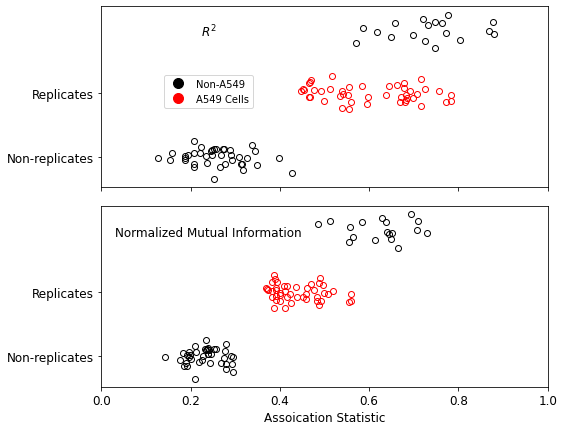

In [10]:
## Call a figure and set its color
fig,ax = plt.subplots(2,1,figsize=(8,7),sharex=True,sharey=True)
fig.set_facecolor('w')

## Iterate thru the stat choices
for i,s in enumerate(['Rsq','Nmi']):
    
    ## Set the axis
    plt.sca(ax[i])
    
    ## Reset y ticks
    plt.yticks([0,1],['Non-replicates','Replicates'],fontsize=12)
    
    ## Set xlimits
    plt.xlim(0,1)
    
    ## reset xticks
    plt.xticks(fontsize=12)

    ## Set title
    plt.title(mylabels[i],fontsize=12, x=0.24,y=0.8)

    ## Iterate thru long dataframe
    for ri,row in newdf.iterrows():
        
        ## Gather variables
        y,x,c = row.Isrep,row[s],row['Color']
        
        ## Plot data
        plt.plot(x,y+noise[ri],'o',color=c,fillstyle='none')
        
## Add an x axis label
plt.xlabel('Assoication Statistic',fontsize=12)
        
## Ret axis coordiantes
plt.sca(ax[0])

## Make a legend
plt.plot(0.5,0.5,'ko',ms=10, label='Non-A549')
plt.plot(0.5,0.5,'ro',ms=10, label='A549 Cells')
plt.plot(0.5,0.5,'wo',ms=20)

## make legend
plt.legend(bbox_to_anchor=(0.35,0.65))
         
## Addjust distance between plates
plt.subplots_adjust(hspace=0.1);

In [11]:
## Set class 
newdf['Class'] = newdf.Isrep

In [12]:
## View the resluts of A549, replicate comparisons
newdf[(newdf.Color=='r') & (newdf.Isrep==1)].shape

(45, 11)

In [13]:
## Random Forests
## Set number of estimators and selection criterion
n_ests, select_criterion, testsize = 100, 'entropy', 0.4

In [14]:
## Set the features and target
target, features = 'Class', ['Rsq','Nmi']

## Set the x and y variables
X, y = newdf[features].values, newdf[target].values

## Split the data, stratifying on y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, stratify=y)

In [15]:
## Create a Gaussian Classifier
clf=RandomForestClassifier(criterion=select_criterion)

## Train the model using the training sets
clf.fit(X_train,y_train)

## Calculate the feature importance
feature_imp = pd.Series(clf.feature_importances_,index=features)

## Set the new index
feature_imp.index = ['\n'.join(k.split(' ')) for k in mylabels]

In [16]:
## Make the prediction on test
y_pred=clf.predict(X_test)

## Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

## Calcu the accuracy
asc = accuracy_score(y_test, y_pred)

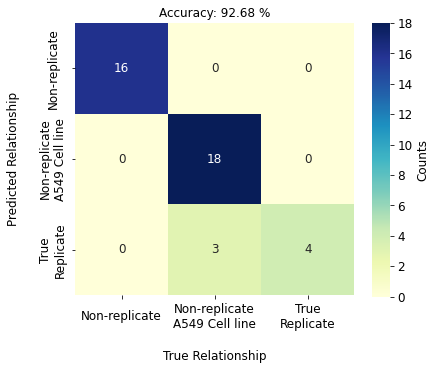

In [17]:
## Call a figure
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.set_facecolor('w')

## Add heat map of forest results
## Add color bar axis
ac = fig.add_axes([0.95,0.12,0.05,0.76])

## Plot a heatmap
sns.heatmap(cm,annot=True,cbar_ax=ac,annot_kws={'fontsize':12},ax=ax,cmap="YlGnBu")

## Addjust and annotate counts bar
plt.sca(ac);plt.yticks(fontsize=12);plt.ylabel('Counts',fontsize=12)

## Set the axes, adjust xticks
plt.sca(ax);plt.xticks(fontsize=12);plt.yticks(fontsize=12)

## Add x and y labels
plt.xlabel('\nTrue Relationship',fontsize=12);plt.ylabel('Predicted Relationship\n',fontsize=12);

## Add a title
plt.title('Accuracy: %s %s'%(np.round(100*asc,2),'%'),fontsize=12)

## Set the new x and y tick lables
newxticks = ['\n\nNon-replicate','\n\nNon-replicate\nA549 Cell line','\n\nTrue\nReplicate']
newyticks = ['Non-replicate\n\n','Non-replicate\nA549 Cell line\n\n','True\nReplicate\n\n']

## Adjust x and y ticks
plt.xticks([0.5,1.5,2.5],newxticks,va='center',ha='center');
plt.yticks([0.5,1.5,2.5],newyticks,va='center',ha='center');

In [18]:
## Print the clasification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.86      1.00      0.92        18
           2       1.00      0.57      0.73         7

    accuracy                           0.93        41
   macro avg       0.95      0.86      0.88        41
weighted avg       0.94      0.93      0.92        41



In [19]:
## Place a break to stop code
assert len(features) > 1, "Encountered and early stop!"

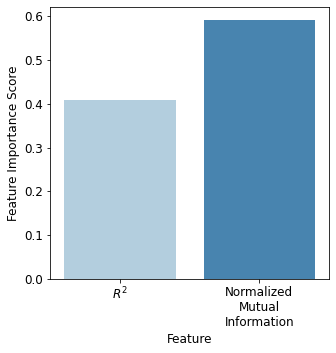

In [20]:
## Call a figure, set face color
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.set_facecolor('w')

## Visulize feature scores,via a bar plot
sns.barplot(y=feature_imp, x=feature_imp.index,palette='Blues')

## Adjust x ticks and x lable
plt.xticks(fontsize=12);plt.xlabel('Feature',fontsize=12)

## Adjust yticks and y label
plt.yticks(fontsize=12);plt.ylabel('Feature Importance Score',fontsize=12);

In [21]:
## Set the x and y variables
X, y, kfold_imp, kfold_asc, nsplits, classreports = newdf[features].values, newdf[target].values, [], [], 10, []

## Make the stratified shuffle splits
skf = StratifiedShuffleSplit(n_splits=nsplits, test_size=testsize, random_state=0)

## Iterate thru the folds
for train_ix, test_ix in skf.split(X,y):
        
    ## Split the train and test
    X_train,y_train,X_test,y_test = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
    
    ## Fit the random forest classifier
    clf.fit(X_train,y_train)
    
    ## Calculate the feature importance
    feature_imp = pd.Series(clf.feature_importances_,index=features)
    
    ## Append our feture_imp
    kfold_imp.append(feature_imp)
    
    ## Make the prediction on test
    y_pred=clf.predict(X_test)

    ## Calcu the accuracy
    asc = accuracy_score(y_test, y_pred)
    
    ## Append our acurracy
    kfold_asc.append(asc)
    
    ## Print the clasification report
    cr = classification_report(y_test,y_pred,output_dict=True)
    
    ## Append the class reports
    classreports.append(cr)
    
## Make into a datarame
kfold_res = pd.concat(kfold_imp,axis=1).T

## Add accuracy
kfold_res['Accuracy'] = kfold_asc

In [22]:
## Print the new labels
mynewlabels = [mylabels[0] , '\n'.join(mylabels[1].split(' '))]
mynewlabels

['$R^2$', 'Normalized\nMutual\nInformation']

In [23]:
## Calculate feature importance scores 
features_imps = pd.DataFrame([kfold_res['Rsq'].tolist() + kfold_res['Nmi'].tolist(),
                         [mynewlabels[0] for i in range(nsplits)] + [mynewlabels[1] for i in range(nsplits)]],
                        
                       index=['Score','Feature']).T

features_imps.head()

,Score,Feature
0,0.45774,$R^2$
1,0.55046,$R^2$
2,0.439666,$R^2$
3,0.514118,$R^2$
4,0.37453,$R^2$


In [24]:
## Bring in scipy stats 
import scipy.stats as ss

## Run wilcoxon
ttest,pval = ss.wilcoxon(kfold_res.Rsq.values,kfold_res.Nmi.values)

## Print pvalue 
pval

0.048828125

In [25]:
## Calcluate mean diff 
np.mean(kfold_res.Nmi.values - kfold_res.Rsq.values)*100

6.783384124854135

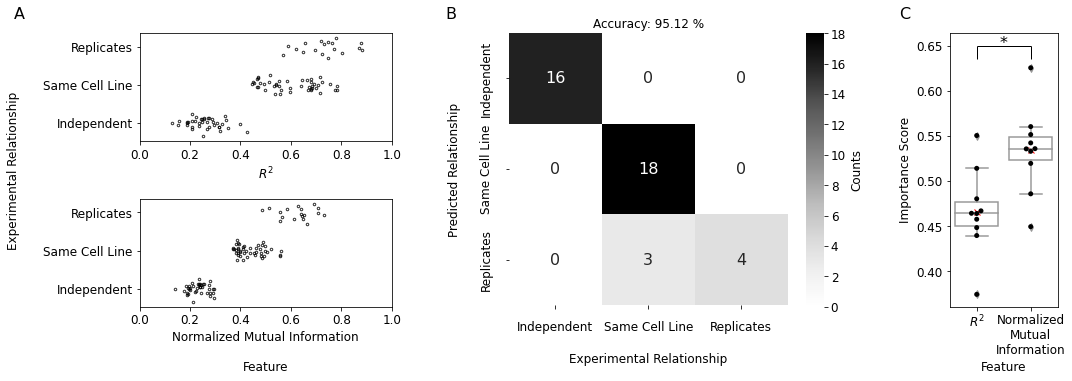

In [26]:
## Call a figure, set facecolor 
fig,ax = plt.subplots(1,1,figsize=(5,5))
fig.set_facecolor('w')

## Plot the replicate NMI and R2 scores
## Make axis for plotting the data
a1 = fig.add_axes([-0.9,0.58,0.7,0.3])
a2 = fig.add_axes([-0.9,0.12,0.7,0.3])

## Iterate thru the stat choices
for i,s in enumerate(['Rsq','Nmi']):
    
    ## Set the axis
    plt.sca([a1,a2][i])

    ## Reset y ticks 
    plt.yticks([0,1,2],['Independent','Same Cell Line','Replicates'],fontsize=12)
    
    ## Set ylabel
    thexlabel = mylabels[i] if i == 0 else mylabels[i] + '\n\nFeature'
    
    ## Set xlimits, xticks fontsizes, and xlabel
    plt.xlim(0,1);plt.xticks(fontsize=12);plt.xlabel(thexlabel,fontsize=12)

    ## Iterate thru long dataframe
    for ri,row in newdf.iterrows():
        
        ## Gather variables`
        #y,x,c = row.Isrep, row[s], row['Color']
        y,x,c = row.Class, row[s], row['Color']
        
        ## set the marker based on color
        #m = '.' if c == 'r' else '^'
        m = '.'
        c = 'k'
        
        ## Plot data
        plt.plot(x,y+noise[ri],m,color=c,fillstyle='none',ms=5,alpha=0.8)
        
## Ret axis coordiantes
plt.sca(a1)

## Make a legend
plt.plot(0,0.5,'o', ms=8, label='A549 Cells',color='r',fillstyle='none')
plt.plot(0,0.5,'^', ms=8, label='Non-A549',  color='k',fillstyle='none')
plt.plot(0,0.5,'wo',ms=20)

## make legend
#plt.legend(loc=2,title='Cell Type')#bbox_to_anchor=(0.35,0.65))

## Add heat map of forest results
## Add color bar axis
ac = fig.add_axes([0.95,0.12,0.05,0.76])

## Plot a heatmap
sns.heatmap(cm,annot=True,cbar_ax=ac,annot_kws={'fontsize':16},ax=ax,cmap='Greys')

## Addjust and annotate counts bar
plt.sca(ac);plt.yticks(fontsize=12);plt.ylabel('Counts',fontsize=12)

## Set the axes, adjust xticks
plt.sca(ax);plt.xticks(fontsize=12);plt.yticks(fontsize=12)

## Add x and y labels
plt.xlabel('\nExperimental Relationship',fontsize=12);plt.ylabel('Predicted Relationship\n',fontsize=12);

## Add a title
plt.title('Accuracy: %s %s'%(np.round(100*asc,2),'%'),fontsize=12)

## Set the new x and y tick lables
#newxticks = ['\n\nNon-replicate','\n\nNon-replicate\nSame Cell Line','\n\nTrue\nReplicate']
#newyticks = ['Non-replicate\n\n','Non-replicate\nSame Cell Line\n\n','True\nReplicate\n\n']

## Set the new x and y tick lables
newxticks = ['\n\nIndependent','\n\nSame Cell Line','\n\nReplicates']
newyticks = ['Independent\n\n','Same Cell Line\n\n','Replicates\n\n']

## Adjust x and y ticks
plt.xticks([0.5,1.5,2.5],newxticks,va='center',ha='center');
plt.yticks([0.5,1.5,2.5],newyticks,va='center',ha='center');

## Plot feature scores
## Add an additonal figure
af = fig.add_axes([1.35,0.12,0.3,0.76])

## Set axis
plt.sca(af)

## Make a boxplots
sns.boxplot(x='Feature',y='Score',data=features_imps,color='w')

## Add a swarm
sns.swarmplot(x='Feature',y='Score',data=features_imps,color='k')

## plot the mean
plt.plot([0,1],kfold_res.mean()[['Rsq','Nmi']],'rx');

## Add ylable
plt.yticks(fontsize=12);plt.ylabel('Importance Score',fontsize=12);

## Addjust xticks and lables
plt.xticks(fontsize=12);plt.xlabel('Feature',fontsize=12);

## Add lines for annotating with p-value
[plt.vlines(i,0.635,0.65,color='k',linewidth=1) for i in [0,1]]
plt.hlines(0.65,0,1,color='k',linewidth=1)

## Add a signle asstrics
plt.text(0.5,0.653,'*' if pval<0.05 else None,fontsize=16,va='center',ha='center');

## Add A - C lables
[fig.text(x,0.92,l,fontsize=16) for x,l in zip([-1.25,-0.05,1.21],['A','B','C'])];

## Set the save path
#savepath = '/Users/croth/Documents/A549_bed_counts/Figure.5.png'

## Set the ylabel
fig.text(-1.25,0.5,'Experimental Relationship',fontsize=12,va='center',ha='center',rotation=90);

## Save the figire
#plt.savefig(savepath,bbox_inches='tight',dpi=600);

In [27]:
## Set legend size 
plt.rcParams['legend.title_fontsize'] = 'large'

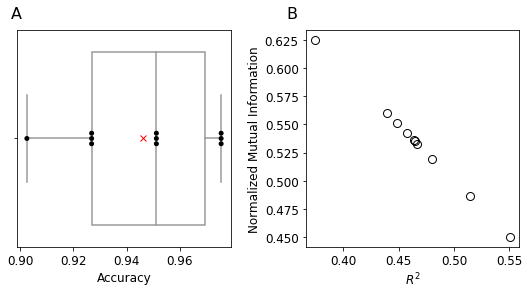

In [28]:
## Call a figure and set facecolor
fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.set_facecolor('w')

## SEt the first axis and plot the nmi vs the r2 from 10 cv
plt.sca(ax[1])
plt.plot(kfold_res.Rsq.values, kfold_res.Nmi.values,'ko',fillstyle='none',ms=8);

## ADd y and x lables
plt.xlabel(mynewlabels[0],fontsize=12);plt.xticks(fontsize=12)
plt.ylabel(mylabels[1],fontsize=12);plt.yticks(fontsize=12)

## Plot the accuracy scores across our cvs
plt.sca(ax[0])

## make a boxplot via seaborn
sns.boxplot(x='Accuracy',data=kfold_res,color='w',fliersize=0)

## plot the swram of points
sns.swarmplot(x='Accuracy',data=kfold_res,color='k');

## Plot the mean
plt.plot(kfold_res.Accuracy.mean(),0,'rx');

## Set fontsize of x-axis
plt.xlabel('Accuracy',fontsize=12);plt.xticks(fontsize=12);

## Add A - B lables
[fig.text(x,0.92,l,fontsize=16) for x,l in zip([0.115,0.54],['A','B'])];

## Set the savepath
#savepath = '/Users/croth/Documents/A549_bed_counts/S.Figure.3.png'

## Addjust the distance between plots
plt.subplots_adjust(wspace=0.35);

## Save the figir
#plt.savefig(savepath,bbox_inches='tight',dpi=300);

In [29]:
## Initlize reports and accuracy scores 
reports, accus = [],[]

## Iterate thru the reports 
for i,rep in enumerate(classreports):
    for c in ['0','1','2']:
        for p in ['f1-score','recall','precision']:
            x = rep[c][p]
            
            ## Append teh reports 
            reports.append((i,c,p,x))
            
    ## append accuracy
    accus.append(rep['accuracy'])
        
## Format report into dataframe 
reports = pd.DataFrame(reports,columns = ['Report','Class','Metric','Score'])    

## show the head 
reports.head()

,Report,Class,Metric,Score
0,0,0,f1-score,1.0
1,0,0,recall,1.0
2,0,0,precision,1.0
3,0,1,f1-score,0.9
4,0,1,recall,1.0


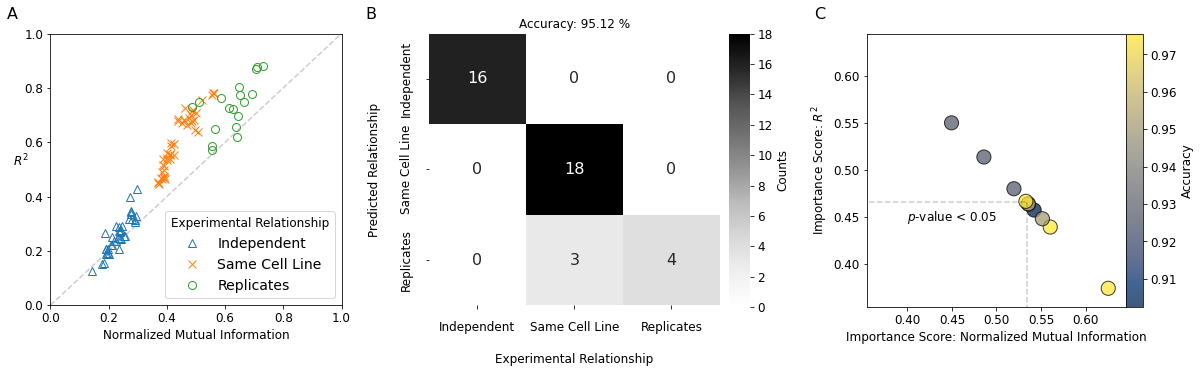

In [30]:
## Call a figure
fig,ax = plt.subplots(1,2,figsize=(12,5))
fig.set_facecolor('w')

## Plot the replicate NMI and R2 scores
## Add a scatter plot of nmi vs rsq
plt.sca(ax[0]);

## Add a one to one line
plt.plot([0,1],[0,1],'k--',alpha=0.2)

## Set the experimental labels
explabels = ['Independent','Same Cell Line','Replicates']

## Set marksers
expmark = ['^','x','o']

## Plot the scores
for g,df in newdf.groupby('Class'):
    plt.plot(df.Nmi.values,df.Rsq.values,expmark[g],ms=8,fillstyle='none',label=explabels[g]);

## Add y and x lables
plt.xlabel(mylabels[1], fontsize=12);plt.xticks(fontsize=12)
plt.ylabel(mylabels[0], fontsize=12,rotation=0);plt.yticks(fontsize=12)

## Addjust x and y limits
plt.xlim(0,1);plt.ylim(0,1)

## Set legend title
legend_title = 'Experimental Relationship'

## make legend
plt.legend(loc=0,title=legend_title,fontsize=14)

## Add heat map of forest results, add color bar axis
ac = fig.add_axes([0.91,0.12,0.025,0.76])

## Plot a heatmap
sns.heatmap(cm,annot=True,cbar_ax=ac,annot_kws={'fontsize':16},ax=ax[1],cmap='Greys')

## Addjust and annotate counts bar
plt.sca(ac);plt.yticks(fontsize=12);plt.ylabel('Counts',fontsize=12)

## Set the axes, adjust xticks
plt.sca(ax[1]);plt.xticks(fontsize=12);plt.yticks(fontsize=12)

## Add x and y labels
plt.xlabel('\n'+legend_title,fontsize=12);
plt.ylabel('Predicted Relationship\n',fontsize=12);

## Add a title
plt.title('Accuracy: %s %s'%(np.round(100*asc,2),'%'),fontsize=12)

## Set the new x and y tick lables
newxticks = ['\n\n'+el for el in explabels]
newyticks = [el+'\n\n' for el in explabels]

## Adjust x and y ticks
plt.xticks([0.5,1.5,2.5],newxticks,va='center',ha='center');
plt.yticks([0.5,1.5,2.5],newyticks,va='center',ha='center');

## Plot feature scores
## Add an additonal figure
af = fig.add_axes([1.07,0.12,0.3,0.76])
az = fig.add_axes([1.37,0.12,0.02,0.76])

## Set axis
plt.sca(af)

## Plot mean lines 
plt.vlines(np.mean(kfold_res.Nmi),0,np.mean(kfold_res.Rsq),linestyle='--',color='k',alpha=0.2)
plt.hlines(np.mean(kfold_res.Rsq),0,np.mean(kfold_res.Nmi),linestyle='--',color='k',alpha=0.2)

## Annotate p-value
plt.text(0.45,0.45,'$p$-value < 0.05' if round(pval,4) < 0.05 else None,va='center',ha='center',fontsize=12)

## Plot the feature importnace scores and color by accuracy 
plt.scatter(x=kfold_res.Nmi,y=kfold_res.Rsq,c=kfold_res.Accuracy.values,s=200,marker='o',alpha=0.75,cmap='cividis',edgecolors='k');

## Addjust x and y ticks 
plt.xticks(fontsize=12);plt.yticks(fontsize=12)

## Add x and y axis labels
plt.xlabel('Importance Score: '+ mylabels[-1],fontsize=12)
plt.ylabel('Importance Score: '+ mylabels[0], fontsize=12)

## Set the axis, min and max
axis_min = kfold_res[['Rsq','Nmi']].min().min()-0.02
axis_max = kfold_res[['Rsq','Nmi']].max().max()+0.02

## Set the x and y limis
plt.xlim(axis_min,axis_max)
plt.ylim(axis_min,axis_max)

## Set axis to color bar axi
plt.sca(az)

## Set color bar 
plt.colorbar(cax=az)

## Set yticks
plt.yticks(fontsize=12);plt.ylabel('Accuracy',fontsize=12)

## Add A - C lables
[fig.text(x,0.92,l,fontsize=16) for x,l in zip([0.075,0.49,1.009],['A','B','C'])]

## Add just subplots
plt.subplots_adjust(wspace=0.3);

## Set the save path
savepath = '../FIGURES/Figure.5.png'

## Save the figire
plt.savefig(savepath,bbox_inches='tight',dpi=600);

/Users/croth/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


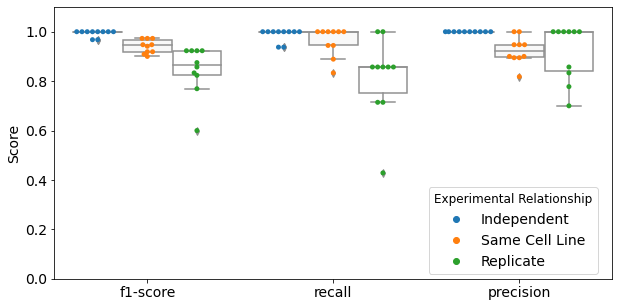

In [31]:
## Call figure 
fig,ax = plt.subplots(1,1,figsize=(10,5))
fig.set_facecolor('w')

## Add box and swarm plot 
sns.boxplot(x='Metric',y='Score',data=reports,hue='Class',color='w',dodge=True)
sns.swarmplot(x='Metric',y='Score',data=reports,hue='Class',dodge=True);

## Set ylimits
plt.ylim(0,1.1)

## Remove legend
legend = ax.legend()
legend.remove()

## Remove xlabel and add ylable 
plt.xlabel('');plt.ylabel('Score',fontsize=14)

## Adjust yticks 
plt.xticks(fontsize=14);plt.yticks(fontsize=14)

## Set legend axis 
legax = fig.add_axes([0.79,0.3,0.1,0.1])

## Plot points to make fake legend 
plt.plot(0,0.5,'o',color='tab:blue',label='Independent')
plt.plot(0,0.5,'o',color='tab:orange',label='Same Cell Line')
plt.plot(0,0.5,'o',color='tab:green',label='Replicate')
plt.plot(0,0.5,'wo',ms=10)
plt.axis('off')

## Add legend 
plt.legend(fontsize=14,title='Experimental Relationship');

## Set the save path
savepath = '../FIGURES/S.Figure.7.png'

## Addjust the distance between plots
plt.subplots_adjust(wspace=0.35);

## Save the figir
plt.savefig(savepath,bbox_inches='tight',dpi=300);

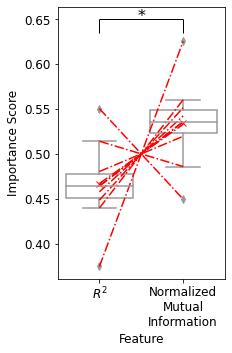

In [32]:
## Call a figure
fig,ax = plt.subplots(1,1,figsize=(3,5))

## Make a boxplots
sns.boxplot(x='Feature',y='Score',data=features_imps,color='w')

## Add a swarm
#sns.swarmplot(x='Feature',y='Score',data=features_imps,color='k')
plt.plot([0,1],kfold_res[['Rsq','Nmi']].T.values,'r-.')

## plot the mean
plt.plot([0,1],kfold_res.mean()[['Rsq','Nmi']],'rx');

## Add ylable
plt.yticks(fontsize=12);plt.ylabel('Importance Score',fontsize=12);

## Addjust xticks and lables
plt.xticks(fontsize=12);plt.xlabel('Feature',fontsize=12);

## Add lines for annotating with p-value
[plt.vlines(i,0.635,0.65,color='k',linewidth=1) for i in [0,1]]
plt.hlines(0.65,0,1,color='k',linewidth=1)

## Add a signle asstrics
plt.text(0.5,0.653,'*' if pval<0.05 else None,fontsize=16,va='center',ha='center');

In [33]:
## Bring in the ols mods
from statsmodels.formula.api import ols

In [34]:
## reset class to is rep 
longdf['Class'] = longdf['Isrep']

In [35]:
## Make the long df into a longer df
## Get Rsq
tmp1 = longdf[['Rsq','Class']].copy()
tmp1['Stat'] = 'Rsq'
tmp1['S'] = tmp1.Rsq

## Parse NMI
tmp2 = longdf[['Nmi','Class']].copy()
tmp2['Stat'] = 'Nmi'
tmp2['S'] = tmp2.Nmi

## Concat
snsdf = pd.concat([tmp1[['Class','Stat','S']],tmp2[['Class','Stat','S']]])
snsdf.tail()

,Class,Stat,S
271,0,Nmi,0.199319
272,0,Nmi,0.201756
273,0,Nmi,0.211518
274,0,Nmi,0.211110
275,2,Nmi,0.640475


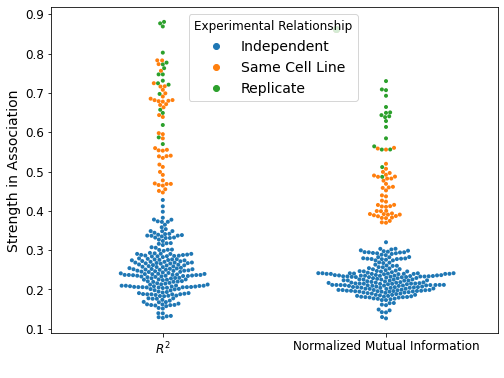

In [36]:
## Call a figure set facecolor to w
fig,ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')

## Call a swarm plot 
g = sns.swarmplot(x='Stat',y='S',hue='Class',data=snsdf,size=4);

## Remove the legend
g.legend_.remove()

## Print the y and x ticks and set labels 
plt.yticks(fontsize=12);plt.ylabel('Strength in Association',fontsize=14)
plt.xticks([0,1],mylabels,fontsize=12);plt.xlabel(' ')

## Set an axis for a new legend
legax = fig.add_axes([0.57,0.78,0.1,0.1])

## Plot points to make fake legend 
colors = ['tab:%s'%s for s in ('blue','orange','green')]
labels = ['Independent','Same Cell Line','Replicate']

## Zip and loop over lables and colors 
for c,l in zip(colors,labels):
    plt.plot(0,0,'o',color=c,label=l)

## Remove the axis
plt.axis('off')

## Add legend 
plt.legend(fontsize=14,title='Experimental Relationship');

## Set save path
savepath = None #  '../FIGURES/S.Figure.8.png'

## Save the figure
if savepath:
    plt.savefig(savepath,dpi=300,bbox_inches='tight');

In [37]:
## Set the formula we want to test in linear model 
formulas = ['Class ~ Nmi + Rsq','Class ~ Rsq','Class ~ Nmi']

## Iterate thru the formula 
for f in formulas:
    
    ## Set the model 
    model = ols(f, data=longdf)
    
    ## Fit the model 
    results = model.fit()
    
    ## Print model and results 
    print(f)
    print(results.summary())
    print('\n\n\n')

Class ~ Nmi + Rsq
                            OLS Regression Results                            
Dep. Variable:                  Class   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1059.
Date:                Fri, 30 Jun 2023   Prob (F-statistic):          2.38e-129
Time:                        11:59:14   Log-Likelihood:                 57.573
No. Observations:                 276   AIC:                            -109.1
Df Residuals:                     273   BIC:                            -98.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9588      0.032  